In [1]:
!pip install transformers==4.18.0

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno
import tensorflow as tf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from tensorflow.keras.preprocessing import text
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizerFast
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers.trainer_tf import TFTrainer
from transformers import TrainingArguments, Trainer

In [4]:
import nltk
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:
def load_json_file(filename):
    with open(filename) as f:
        file = json.load(f)
    return file

filename = '/content/drive/MyDrive/dataset/intents.json'

intents = load_json_file(filename)

In [6]:
def create_df():
    df = pd.DataFrame({
        'Pattern' : [],
        'Tag' : []
    })

    return df

df = create_df()
df

,Pattern,Tag


In [7]:
def extract_json_info(json_file, df):

    for intent in json_file['intents']:

        for pattern in intent['patterns']:

            sentence_tag = [pattern, intent['tag']]
            df.loc[len(df.index)] = sentence_tag

    return df

df = extract_json_info(intents, df)
df.head()

,Pattern,Tag
0,google,google
1,search,google
2,internet,google
3,Hi there,greeting
4,How are you,greeting


In [8]:
df2 = df.copy()
df2.head()

,Pattern,Tag
0,google,google
1,search,google
2,internet,google
3,Hi there,greeting
4,How are you,greeting


In [9]:
def print_shape_df(df, ds_name="df"):
    print(f"{ds_name} dataset has {df.shape[0]} rows and {df.shape[1]} columns")

print_shape_df(df, "Chatbot")

Chatbot dataset has 113 rows and 2 columns


In [10]:
def print_dfInfo(df, ds_name="df"):
    print(f"The info of {ds_name} dataset\n")
    print(df.info())

print_dfInfo(df, "Chatbot")

The info of Chatbot dataset

<class 'pandas.core.frame.DataFrame'>
Index: 113 entries, 0 to 112
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Pattern  113 non-null    object
 1   Tag      113 non-null    object
dtypes: object(2)
memory usage: 2.6+ KB
None


In [11]:
def num_classes(df, target_col, ds_name="df"):
    print(f"The {ds_name} dataset has {len(df[target_col].unique())} classes")

num_classes(df, 'Tag', "Chatbot")

The Chatbot dataset has 30 classes


In [12]:
def check_null(df, ds_name='df'):
    print(f"Null Values in each col in the {ds_name} dataset:\n")
    print(df.isnull().sum())

check_null(df, "Chatbot")

Null Values in each col in the Chatbot dataset:

Pattern    0
Tag        0
dtype: int64


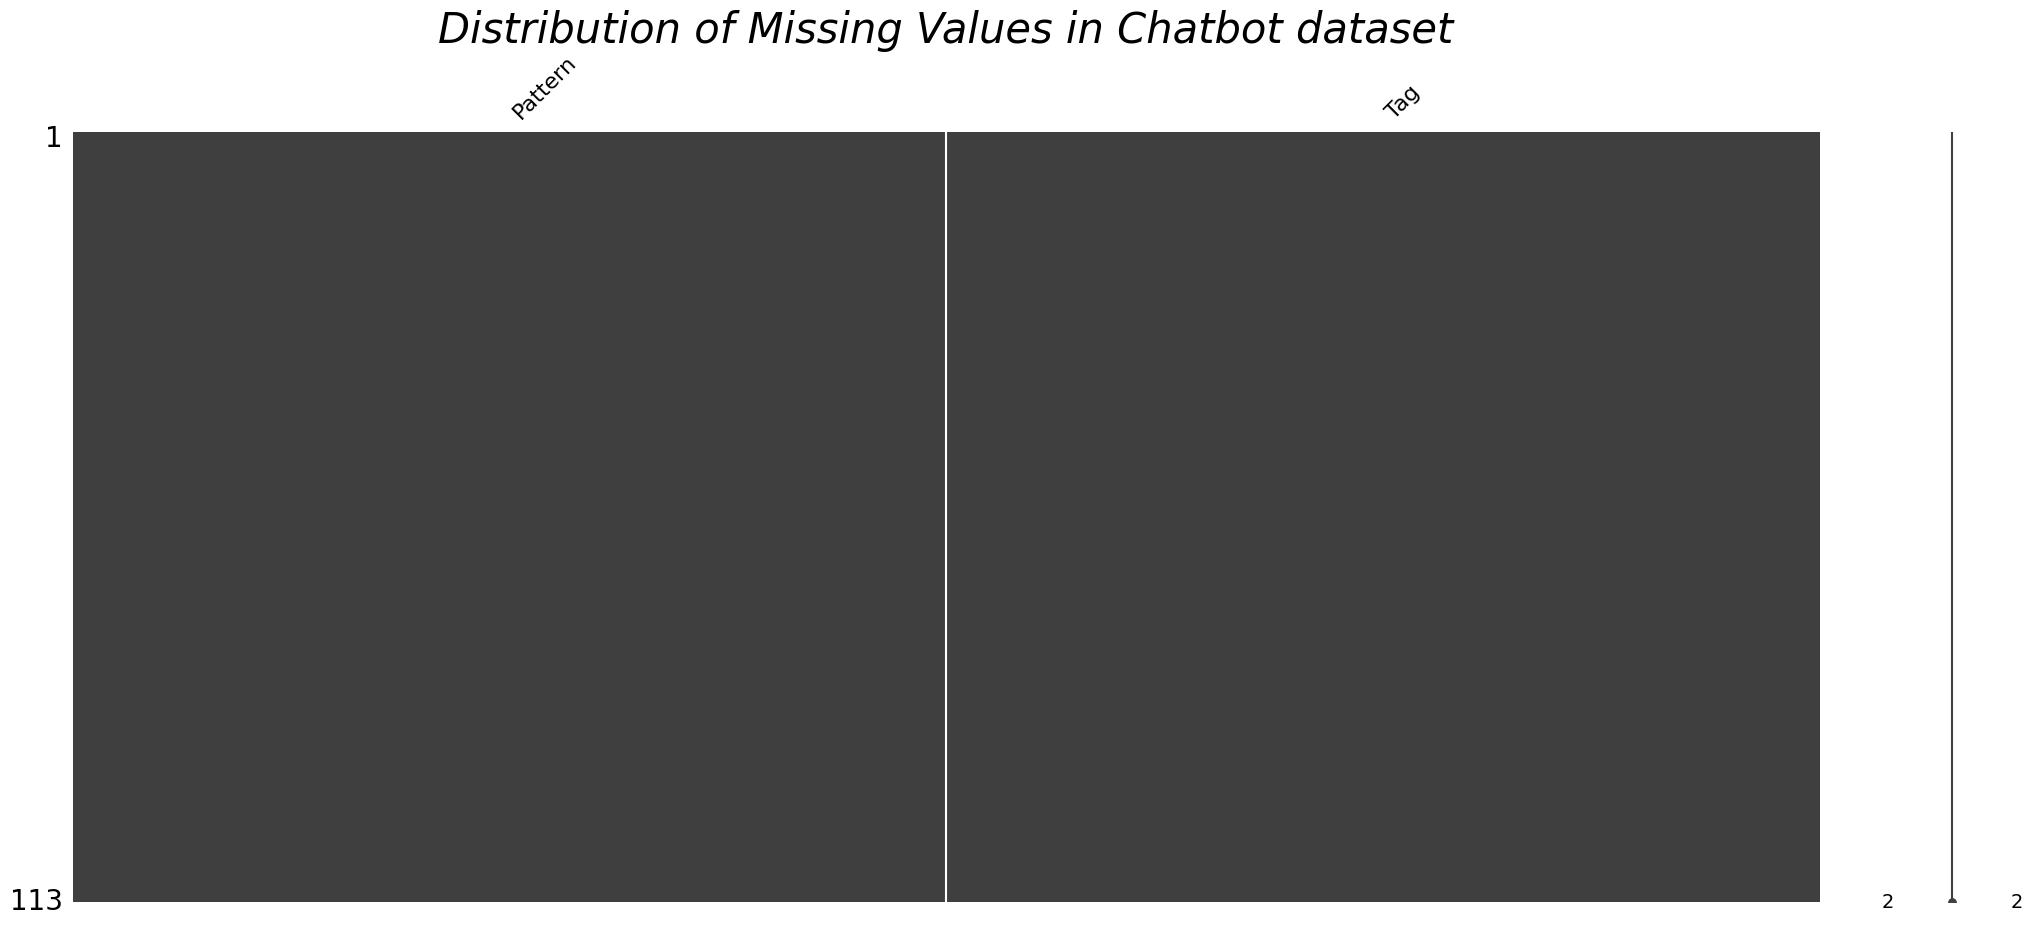

In [13]:
def plot_miss_vals(df, ds_name="df"):
    msno.matrix(df)
    plt.title(f'Distribution of Missing Values in {ds_name} dataset', fontsize=30, fontstyle='oblique')
    plt.show()

plot_miss_vals(df, "Chatbot")

In [14]:
def count_plot(x, df, title, xlabel, ylabel, width, height, order = None, rotation=False, palette='winter', hue=None):
    ncount = len(df)
    plt.figure(figsize=(width,height))
    ax = sns.countplot(x = x, palette=palette, order = order, hue=hue)
    plt.title(title, fontsize=20)
    if rotation:
        plt.xticks(rotation = 'vertical')
    plt.xlabel(xlabel, fontsize=25)
    plt.ylabel(ylabel, fontsize=25)

    ax.yaxis.set_label_position('left')
    for p in ax.patches:
        x=p.get_bbox().get_points()[:,0]
        y=p.get_bbox().get_points()[1,1]
        ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y),
                ha='center', va='bottom') # set the alignment of the text

    plt.show()

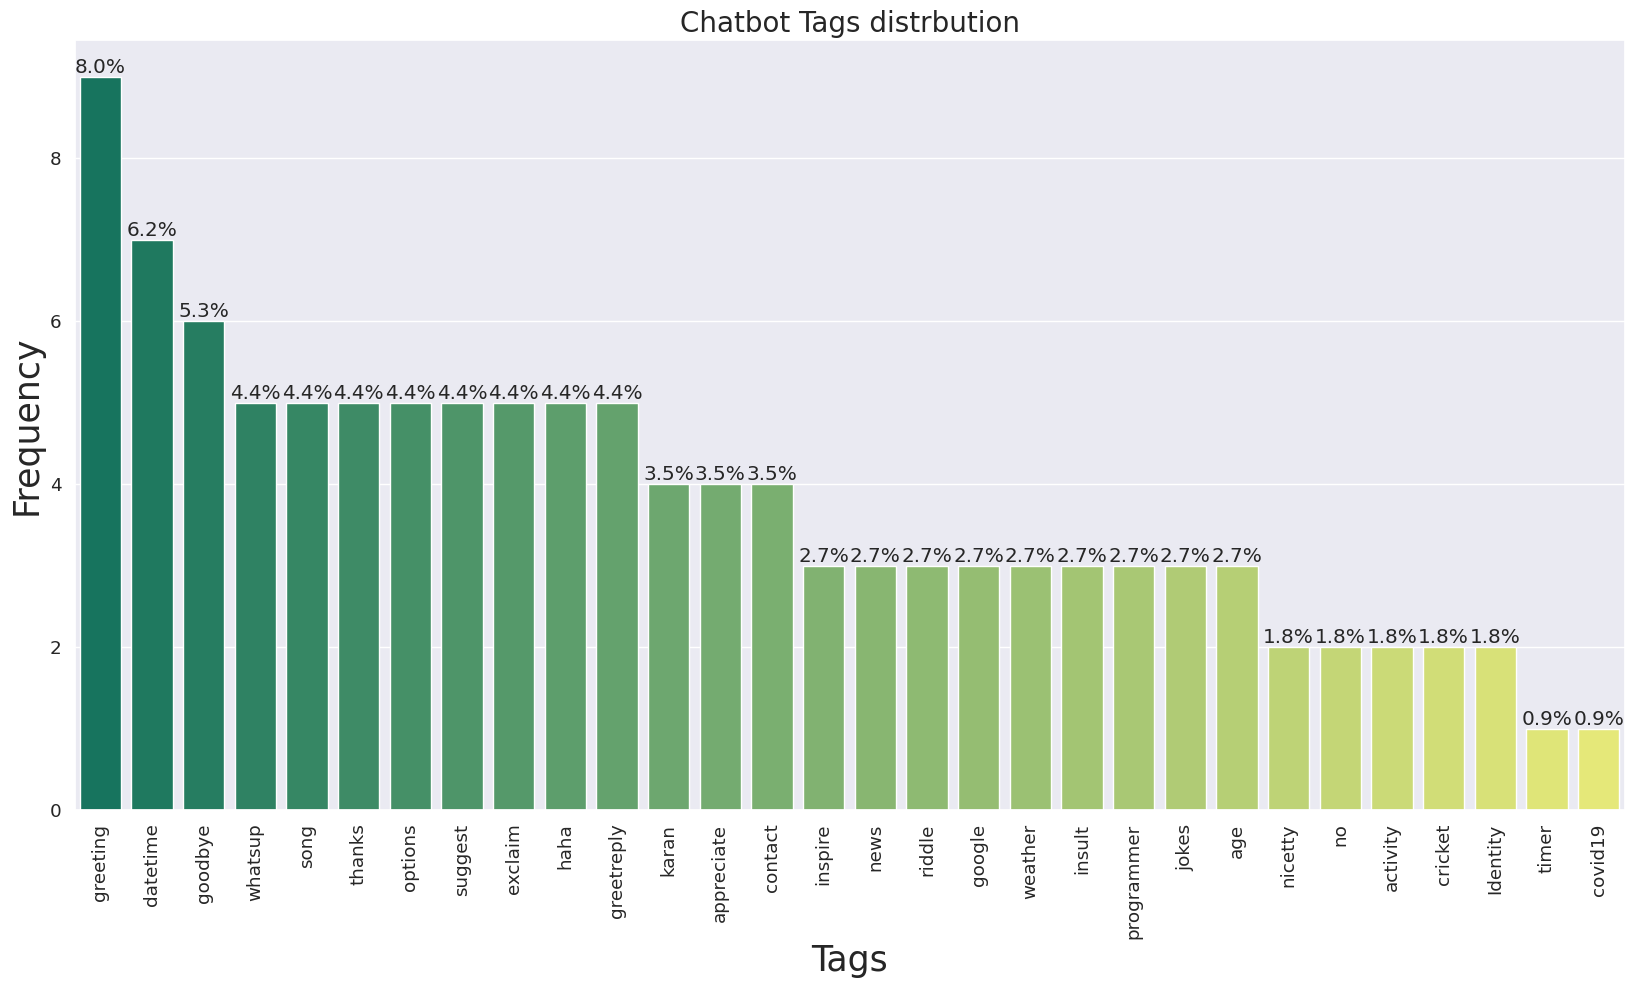

In [15]:
sns.set(font_scale = 1.2)
order = df['Tag'].value_counts().index
count_plot(df['Tag'], df, "Chatbot Tags distrbution", "Tags", "Frequency", 20,10, order=order,rotation=True, palette="summer")

In [16]:
stemmer = PorterStemmer()
ignore_words=['?', '!', ',', '.']

def preprocess_pattern(pattern):
    words = word_tokenize(pattern.lower())
    stemmed_words = [stemmer.stem(word) for word in words if word not in ignore_words]
    return " ".join(stemmed_words)

df['Pattern'] = df['Pattern'].apply(preprocess_pattern)

In [17]:
df.head()

,Pattern,Tag
0,googl,google
1,search,google
2,internet,google
3,hi there,greeting
4,how are you,greeting


In [18]:
print(df['Pattern'].isnull().sum())

0


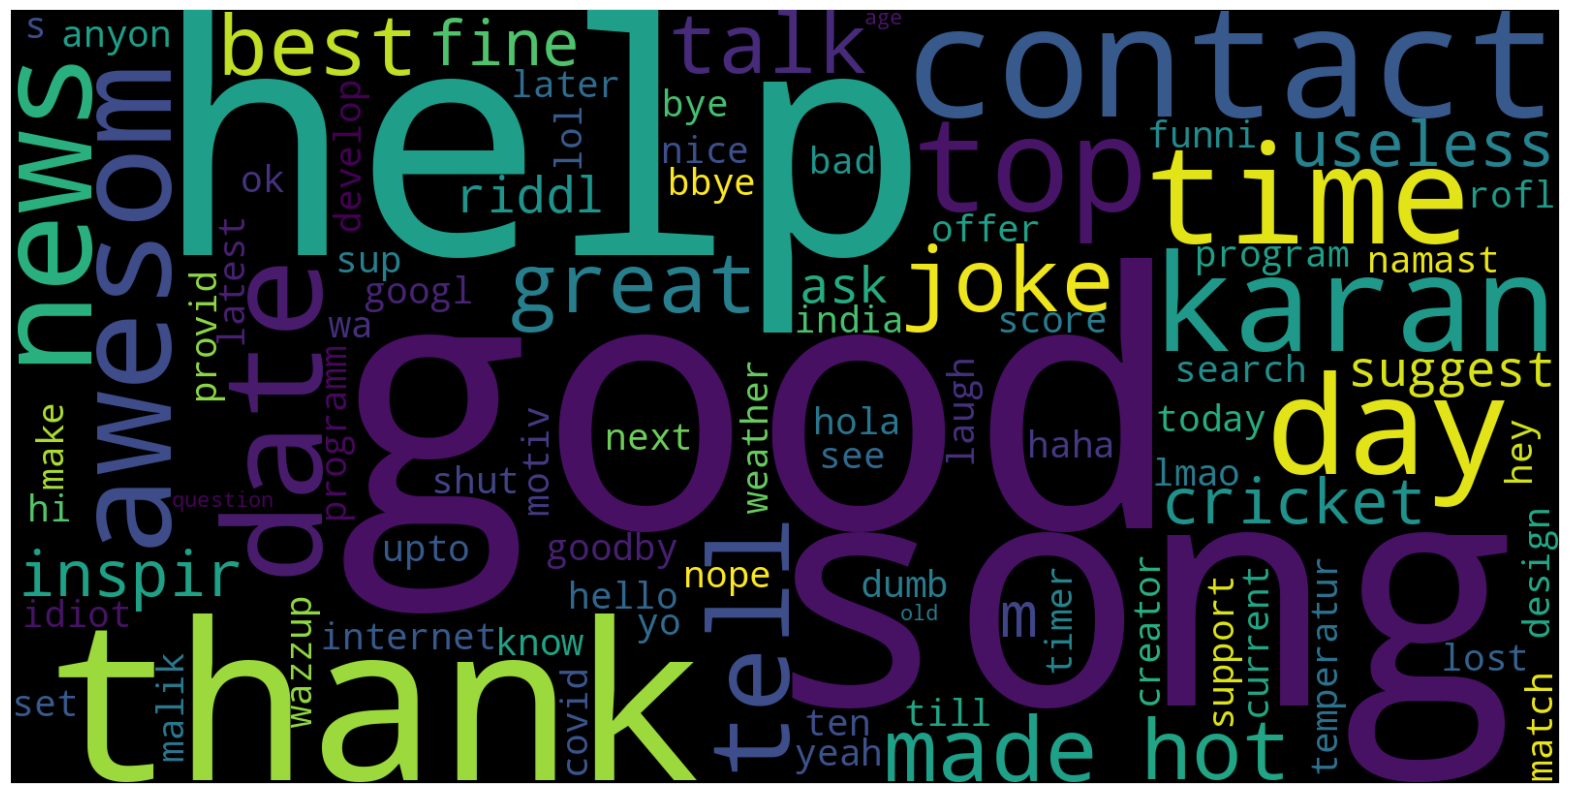

In [19]:
plt.figure(figsize=(20, 20))
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=STOPWORDS).generate(' '.join(df['Pattern']))
plt.imshow(wc, interpolation='bilinear')
plt.xticks([])
plt.yticks([])
plt.show()

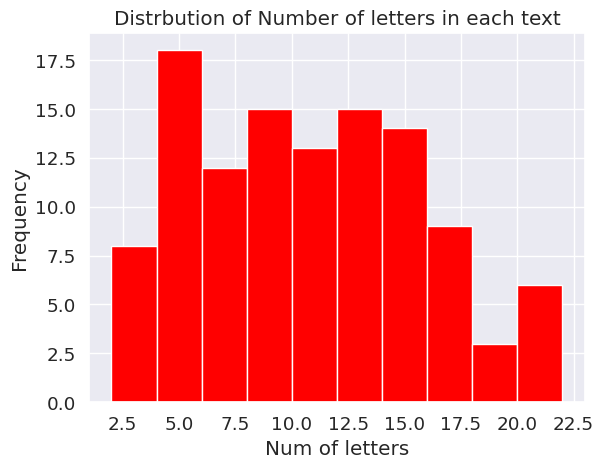

In [20]:
letters_len=df['Pattern'].str.len()
plt.hist(letters_len,color='red')
plt.title("Distrbution of Number of letters in each text")
plt.xlabel("Num of letters")
plt.ylabel("Frequency")
plt.show()

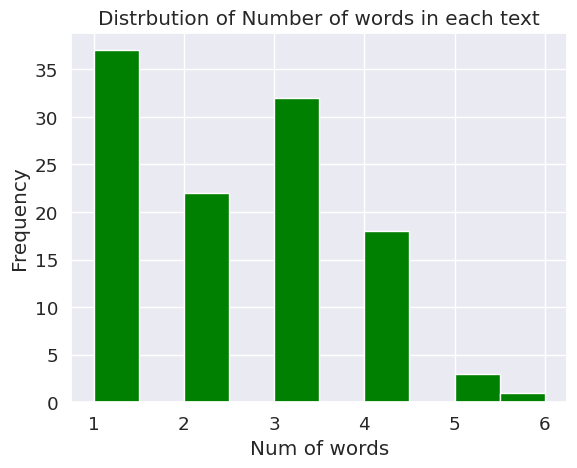

In [21]:
words_len=df['Pattern'].str.split().map(lambda x: len(x))
plt.hist(words_len,color='green')
plt.title("Distrbution of Number of words in each text")
plt.xlabel("Num of words")
plt.ylabel("Frequency")
plt.show()

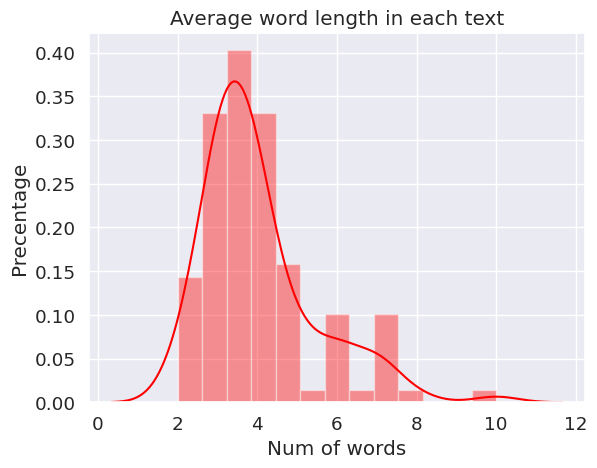

In [22]:
word=df['Pattern'].str.split().apply(lambda x : [len(i) for i in x])
word = word.map(lambda x: np.mean(x))
sns.distplot(word,color='red')
plt.title("Average word length in each text")
plt.xlabel("Num of words")
plt.ylabel("Precentage")
plt.show()

In [23]:
def get_corpus(series):
    words = []
    for text in series:
        for word in text.split():
            words.append(word.strip())
    return words

corpus = get_corpus(df.Pattern)
corpus[:5]

['googl', 'search', 'internet', 'hi', 'there']

In [24]:
print(f"dataset contains {len(corpus)} words")

dataset contains 270 words


In [25]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'you': 28,
 'are': 14,
 'is': 12,
 'what': 11,
 'who': 10,
 'how': 7,
 'me': 7,
 'good': 6,
 'help': 5,
 'i': 5}

In [26]:
def get_top_text_ngrams(corpus, n,g):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

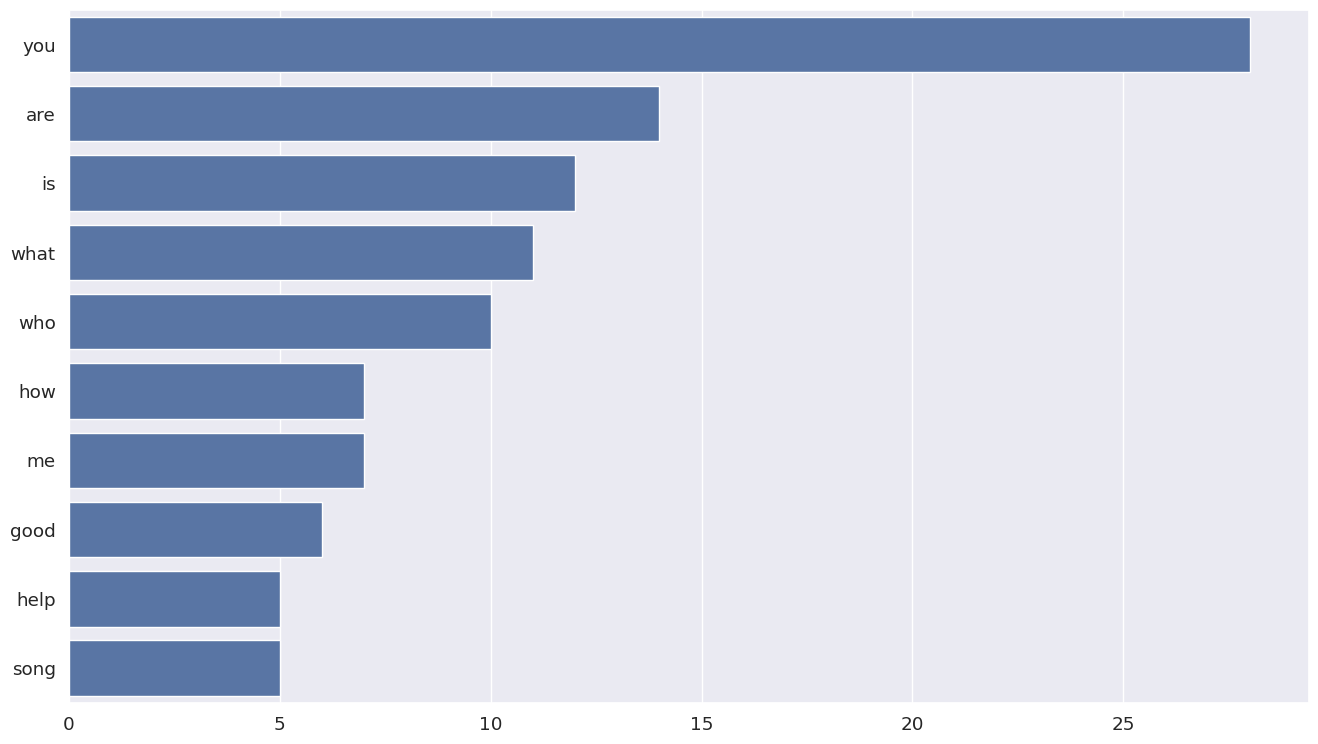

In [27]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.Pattern,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()));

In [28]:
df2.head()

,Pattern,Tag
0,google,google
1,search,google
2,internet,google
3,Hi there,greeting
4,How are you,greeting


In [29]:
labels = df2['Tag'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['google',
 'greeting',
 'goodbye',
 'thanks',
 'options',
 'jokes',
 'Identity',
 'datetime',
 'whatsup',
 'haha',
 'programmer',
 'insult',
 'activity',
 'exclaim',
 'weather',
 'karan',
 'contact',
 'appreciate',
 'nicetty',
 'no',
 'news',
 'inspire',
 'cricket',
 'song',
 'greetreply',
 'timer',
 'covid19',
 'suggest',
 'riddle',
 'age']

In [30]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [31]:
id2label

{0: 'google',
 1: 'greeting',
 2: 'goodbye',
 3: 'thanks',
 4: 'options',
 5: 'jokes',
 6: 'Identity',
 7: 'datetime',
 8: 'whatsup',
 9: 'haha',
 10: 'programmer',
 11: 'insult',
 12: 'activity',
 13: 'exclaim',
 14: 'weather',
 15: 'karan',
 16: 'contact',
 17: 'appreciate',
 18: 'nicetty',
 19: 'no',
 20: 'news',
 21: 'inspire',
 22: 'cricket',
 23: 'song',
 24: 'greetreply',
 25: 'timer',
 26: 'covid19',
 27: 'suggest',
 28: 'riddle',
 29: 'age'}

In [32]:
label2id

{'google': 0,
 'greeting': 1,
 'goodbye': 2,
 'thanks': 3,
 'options': 4,
 'jokes': 5,
 'Identity': 6,
 'datetime': 7,
 'whatsup': 8,
 'haha': 9,
 'programmer': 10,
 'insult': 11,
 'activity': 12,
 'exclaim': 13,
 'weather': 14,
 'karan': 15,
 'contact': 16,
 'appreciate': 17,
 'nicetty': 18,
 'no': 19,
 'news': 20,
 'inspire': 21,
 'cricket': 22,
 'song': 23,
 'greetreply': 24,
 'timer': 25,
 'covid19': 26,
 'suggest': 27,
 'riddle': 28,
 'age': 29}

In [33]:
df2['labels'] = df2['Tag'].map(lambda x: label2id[x.strip()])
df2.head()

,Pattern,Tag,labels
0,google,google,0
1,search,google,0
2,internet,google,0
3,Hi there,greeting,1
4,How are you,greeting,1


In [34]:
X = list(df2['Pattern'])
X[:5]

['google', 'search', 'internet', 'Hi there', 'How are you']

In [35]:
y = list(df2['labels'])
y[:5]

[0, 0, 0, 1, 1]

In [36]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 123)

In [37]:
model_name = "bert-base-uncased"
max_len = 256

tokenizer = BertTokenizer.from_pretrained(model_name,
                                          max_length=max_len)

model = BertForSequenceClassification.from_pretrained(model_name,
                                                      num_labels=num_labels,
                                                      id2label=id2label,
                                                      label2id = label2id)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [38]:
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

In [39]:
full_data = tokenizer(X, truncation=True, padding=True)

In [40]:
class DataLoader(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

In [41]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [42]:
fullDataLoader = DataLoader(full_data, y_test)

In [43]:
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

In [44]:
training_args = TrainingArguments(
    output_dir='./output',
    do_train=True,
    do_eval=True,
    num_train_epochs=100,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.05,
    logging_strategy='steps',
    logging_dir='./multi-class-logs',
    logging_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    load_best_model_at_end=True
)

In [45]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=test_dataloader,
    compute_metrics= compute_metrics
)

In [46]:
trainer.train()

***** Running training *****
  Num examples = 84
  Num Epochs = 100
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 300
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,3.250300,3.155317,0.241379,0.200000,0.218750,0.239583
100,1.894100,2.323076,0.448276,0.394444,0.406250,0.447917
150,0.429200,1.903231,0.482759,0.422222,0.444444,0.435185
200,0.087100,2.014867,0.517241,0.464103,0.480769,0.490385
250,0.047700,2.037800,0.517241,0.464103,0.480769,0.490385
300,0.038200,2.051570,0.517241,0.457692,0.474359,0.490385


***** Running Evaluation *****
  Num examples = 29
  Batch size = 16
***** Running Evaluation *****
  Num examples = 29
  Batch size = 16
***** Running Evaluation *****
  Num examples = 29
  Batch size = 16
***** Running Evaluation *****
  Num examples = 29
  Batch size = 16
***** Running Evaluation *****
  Num examples = 29
  Batch size = 16
***** Running Evaluation *****
  Num examples = 29
  Batch size = 16


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=300, training_loss=0.9577803015708923, metrics={'train_runtime': 1297.745, 'train_samples_per_second': 6.473, 'train_steps_per_second': 0.231, 'total_flos': 34542007718400.0, 'train_loss': 0.9577803015708923, 'epoch': 100.0})

In [47]:
q=[trainer.evaluate(eval_dataset=df2) for df2 in [train_dataloader, test_dataloader]]

pd.DataFrame(q, index=["train","test"]).iloc[:,:5]

***** Running Evaluation *****
  Num examples = 84
  Batch size = 16


***** Running Evaluation *****
  Num examples = 29
  Batch size = 16


,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.026774,1.000000,1.000000,1.000000,1.000000
test,2.051570,0.517241,0.457692,0.474359,0.490385


from matplotlib import pyplot as plt
_df_0['eval_loss'].plot(kind='hist', bins=20, title='eval_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['eval_Accuracy'].plot(kind='hist', bins=20, title='eval_Accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['eval_F1'].plot(kind='hist', bins=20, title='eval_F1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['eval_Precision'].plot(kind='hist', bins=20, title='eval_Precision')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='eval_loss', y='eval_Accuracy', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='eval_Accuracy', y='eval_F1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='eval_F1', y='eval_Precision', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='eval_Precision', y='eval_Recall', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['eval_loss']
  ys = series['eval_Accuracy']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('eval_loss', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('eval_loss')
_ = plt.ylabel('eval_Accuracy')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['eval_loss']
  ys = series['eval_F1']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('eval_loss', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('eval_loss')
_ = plt.ylabel('eval_F1')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['eval_loss']
  ys = series['eval_Precision']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('eval_loss', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('eval_loss')
_ = plt.ylabel('eval_Precision')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['eval_loss']
  ys = series['eval_Recall']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('eval_loss', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('eval_loss')
_ = plt.ylabel('eval_Recall')

from matplotlib import pyplot as plt
_df_12['eval_loss'].plot(kind='line', figsize=(8, 4), title='eval_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['eval_Accuracy'].plot(kind='line', figsize=(8, 4), title='eval_Accuracy')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['eval_F1'].plot(kind='line', figsize=(8, 4), title='eval_F1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['eval_Precision'].plot(kind='line', figsize=(8, 4), title='eval_Precision')
plt.gca().spines[['top', 'right']].set_visible(False)

In [50]:
def predict(text):
    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cpu")
    outputs = model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = model.config.id2label[pred_label_idx.item()]

    return probs, pred_label_idx, pred_label


In [51]:
text = "Hello"
predict(text)

(tensor([[1.0377e-03, 9.5796e-01, 1.8711e-02, 6.4477e-04, 1.3086e-03, 2.9992e-04,
          7.6649e-04, 5.7372e-04, 6.3531e-04, 5.6772e-04, 5.9976e-04, 2.5033e-04,
          4.1123e-04, 8.5076e-04, 6.1195e-04, 1.6239e-03, 2.4875e-03, 8.8015e-04,
          9.8038e-05, 1.0504e-03, 1.0177e-03, 7.1483e-04, 7.9894e-04, 1.1934e-03,
          1.3375e-03, 7.2539e-04, 4.4503e-04, 1.0866e-03, 9.4580e-04, 3.6673e-04]],
        grad_fn=<SoftmaxBackward0>),
 tensor(1),
 'greeting')

In [52]:
model_path = "chatbot"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

Saving model checkpoint to chatbot
Configuration saved in chatbot/config.json
Model weights saved in chatbot/pytorch_model.bin
tokenizer config file saved in chatbot/tokenizer_config.json
Special tokens file saved in chatbot/special_tokens_map.json


('chatbot/tokenizer_config.json',
 'chatbot/special_tokens_map.json',
 'chatbot/vocab.txt',
 'chatbot/added_tokens.json')

In [53]:
!pip install xformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 50.7 MB/s eta 0:00:00


In [55]:
model_path = "chatbot"


model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer= BertTokenizerFast.from_pretrained(model_path)
chatbot= pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

loading configuration file chatbot/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "google",
    "1": "greeting",
    "2": "goodbye",
    "3": "thanks",
    "4": "options",
    "5": "jokes",
    "6": "Identity",
    "7": "datetime",
    "8": "whatsup",
    "9": "haha",
    "10": "programmer",
    "11": "insult",
    "12": "activity",
    "13": "exclaim",
    "14": "weather",
    "15": "karan",
    "16": "contact",
    "17": "appreciate",
    "18": "nicetty",
    "19": "no",
    "20": "news",
    "21": "inspire",
    "22": "cricket",
    "23": "song",
    "24": "greetreply",
    "25": "timer",
    "26": "covid19",
    "27": "suggest",
    "28": "riddle",
    "29": "age"
  },
  "initializer_range

In [56]:
chatbot("Hello")

[{'label': 'greeting', 'score': 0.9579588174819946}]

In [57]:
!zip -r chatbot.zip chatbot/


  adding: chatbot/ (stored 0%)
  adding: chatbot/training_args.bin (deflated 51%)
  adding: chatbot/special_tokens_map.json (deflated 40%)
  adding: chatbot/config.json (deflated 59%)
  adding: chatbot/vocab.txt (deflated 53%)
  adding: chatbot/tokenizer_config.json (deflated 44%)
  adding: chatbot/pytorch_model.bin (deflated 7%)


In [58]:
from google.colab import files
files.download("chatbot.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [59]:
def chat(chatbot):

    print("Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..")
    print("Type 'quit' to exit the chat\n\n")

    text = input("User: ").strip().lower()

    while(text != 'quit'):

        score = chatbot(text)[0]['score']

        if score < 0.8:
            print("Chatbot: Sorry I can't answer that\n\n")
            text = input("User: ").strip().lower()
            continue

        label = label2id[chatbot(text)[0]['label']]
        response = random.choice(intents['intents'][label]['responses'])

        print(f"Chatbot: {response}\n\n")

        text = input("User: ").strip().lower()


In [60]:
chat(chatbot)

Chatbot: Hi! I am your virtual assistance,Feel free to ask, and I'll do my best to provide you with answers and assistance..
Type 'quit' to exit the chat


User: what can you do
Chatbot: Not sure I understand


User: hello
Chatbot: Hello


User: How are you
Chatbot: Sorry I can't answer that


User: quit


In [ ]:
from google.colab import drive
drive.mount('/content/drive')